# 逻辑斯蒂回归模型

上一节课我们学习了简单的线性回归模型，这一节我们会学习第二个模型：逻辑斯蒂回归模型(Logistic Regression)。

逻辑斯蒂回归是一种广义的回归模型，其与多元线性回归有着很多相似之处，模型的形式基本相同，虽然也被称为回归，但是其更多的情况使用在分类问题上，同时又以二分类更为常用。

## 1. 模型形式

逻辑斯蒂回归的模型形式和线性回归一样，都是 $y = wx + b$，其中 $x$ 可以是一个多维的特征，唯一不同的地方在于逻辑斯蒂回归会对 $y$ 作用一个 logistic 函数，将其变为一种概率的结果。 

$$
h_\theta(x) = g(\theta^T x) = \frac{1}{1+e^{-\theta^T x}}
$$

Logistic 函数作为 Logistic 回归的核心，我们下面讲一讲 Logistic 函数，也被称为 Sigmoid 函数。

### 1.1 Sigmoid 函数
Sigmoid 函数非常简单，其公式如下

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Sigmoid 函数的图像如下

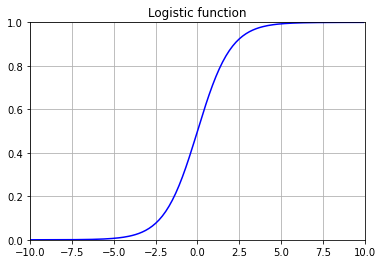

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.axis([-10,10,0,1])
plt.grid(True)
X=np.arange(-10,10,0.1)
y=1/(1+np.e**(-X))
plt.plot(X,y,'b-')
plt.title("Logistic function")
plt.show()


可以看到 Sigmoid 函数的范围是在 0 ~ 1 之间，所以任何一个值经过了 Sigmoid 函数的作用，都会变成 0 ~ 1 之间的一个值，这个值可以形象地理解为一个概率，比如对于二分类问题，这个值越小就表示属于第一类，这个值越大就表示属于第二类。

另外一个 Logistic 回归的前提是确保你的数据具有非常良好的线性可分性，也就是说，你的数据集能够在一定的维度上被分为两个部分，比如

![linear_sep](imgs/linear_sep.png)

可以看到，上面绿色的点和蓝色的点能够几乎被一个黑色的平面分割开来

### 1.2 损失函数
前一节对于回归问题，我们有一个 loss 去衡量误差，那么对于分类问题，我们如何去衡量这个误差，并设计 loss 函数呢？

Logistic 回归使用了 Sigmoid 函数将结果变到 0 ~ 1 之间，对于任意输入一个数据，经过 Sigmoid 之后的结果我们记为 $\hat{y}$，表示这个数据点属于第二类的概率，那么其属于第一类的概率就是 $1-\hat{y}$。如果这个数据点属于第二类，我们希望 $\hat{y}$ 越大越好，也就是越靠近 1 越好，如果这个数据属于第一类，那么我们希望 $1-\hat{y}$ 越大越好，也就是 $\hat{y}$ 越小越好，越靠近 0 越好，所以我们可以这样设计我们的 loss 函数

$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$

其中 y 表示真实的 label，只能取 {0, 1} 这两个值，因为 $\hat{y}$ 表示经过 Logistic 回归预测之后的结果，是一个 0 ~ 1 之间的小数。如果 y 是 0，表示该数据属于第一类，我们希望 $\hat{y}$ 越小越好，上面的 loss 函数变为

$$
loss = - (log(1 - \hat{y}))
$$

在训练模型的时候我们希望最小化 loss 函数，根据 log 函数的单调性，也就是最小化 $\hat{y}$，与我们的要求是一致的。

而如果 y 是 1，表示该数据属于第二类，我们希望 $\hat{y}$ 越大越好，同时上面的 loss 函数变为

$$
loss = -(log(\hat{y}))
$$

我们希望最小化 loss 函数也就是最大化 $\hat{y}$，这也与我们的要求一致。

所以通过上面的论述，说明了这么构建 loss 函数是合理的。

### 1.3 程序示例

下面我们通过例子来具体学习 Logistic 回归

In [75]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 设定随机种子
torch.manual_seed(2021)

我们从 `data.txt` 读入数据。读入数据点之后我们根据不同的 label 将数据点分为了红色和蓝色，并且画图展示出来了

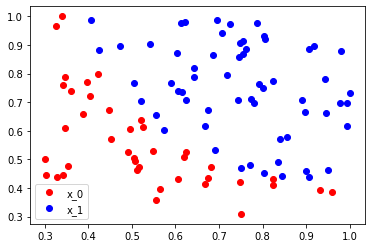

In [76]:
# 从 data.txt 中读入点
with open('./data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]

# 标准化
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

x0 = list(filter(lambda x: x[-1] == 0.0, data)) # 选择第一类的点
x1 = list(filter(lambda x: x[-1] == 1.0, data)) # 选择第二类的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

接下来我们将数据转换成 NumPy 的类型，接着转换到 Tensor 为之后的训练做准备

In [95]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = torch.from_numpy(np_data[:, 0:2]) # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(np_data[:, 2]).unsqueeze(1)

x_data = Variable(x_data)
y_data = Variable(y_data)

在 PyTorch 当中，不需要我们自己写 Sigmoid 的函数，PyTorch 已经用底层的 C++ 语言为我们写好了一些常用的函数，不仅方便我们使用，同时速度上比我们自己实现的更快，稳定性更好。

In [96]:
# 定义 logistic 回归模型
w = Variable(torch.randn(2, 1), requires_grad=True) 
b = Variable(torch.zeros(1), requires_grad=True)

def logistic_regression(x):
    return torch.sigmoid(torch.mm(x, w) + b)

在更新之前，我们可以画出分类的效果

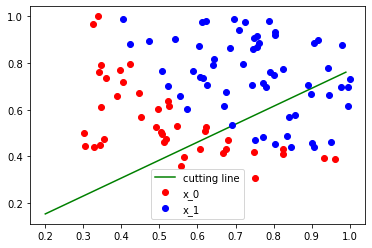

In [97]:
# 画出参数更新之前的结果 
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0.numpy() * plot_x - b0.numpy()) / w1.numpy()

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

可以看到分类效果基本是混乱的，我们来计算一下 loss，公式如下

$$
loss = -\{ y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}) \}
$$

In [98]:
# 计算loss, 使用clamp的目的是防止数据过小而对结果产生较大影响。
def binary_loss(y_pred, y):
    logits = (y * y_pred.clamp(1e-12).log() + \
              (1 - y) * (1 - y_pred).clamp(1e-12).log()).mean()
    return -logits

注意到其中使用 `.clamp`，这是[文档](http://pytorch.org/docs/0.3.0/torch.html?highlight=clamp#torch.clamp)的内容，查看一下，并且思考一下这里是否一定要使用这个函数，如果不使用会出现什么样的结果。

In [100]:
y_pred = logistic_regression(x_data)
loss = binary_loss(y_pred, y_data)
loss.backward()
print(loss)

tensor(0.6824, grad_fn=<NegBackward>)


得到 loss 之后，我们还是使用梯度下降法更新参数，这里可以使用自动求导来直接得到参数的导数，感兴趣的同学可以去手动推导一下导数的公式

In [112]:
# 自动求导并更新参数
for i in range(100):
    # 算出一次更新之后的loss
    y_pred = logistic_regression(x_data)
    loss = binary_loss(y_pred, y_data)
    
    # calc grad & update w,b
    loss.backward()
    w.data = w.data - 0.1 * w.grad.data
    b.data = b.data - 0.1 * b.grad.data

    # clear w,b grad
    w.grad.data.zero_()
    b.grad.data.zero_()
    

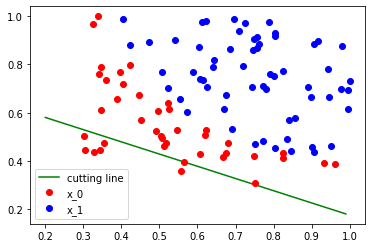

In [113]:
# 画出参数更新之前的结果
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0.numpy() * plot_x - b0.numpy()) / w1.numpy()

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

### 1.4 torch.optim
上面的参数更新方式其实是繁琐的重复操作，如果我们的参数很多，比如有 100 个，那么我们需要写 100 行来更新参数，为了方便，我们可以写成一个函数来更新，其实 PyTorch 已经为我们封装了一个函数来做这件事，这就是 PyTorch 中的优化器 `torch.optim`

使用 `torch.optim` 需要另外一个数据类型，就是 `nn.Parameter`，这个本质上和 Variable 是一样的，只不过 `nn.Parameter` 默认是要求梯度的，而 Variable 默认是不求梯度的

使用 `torch.optim.SGD` 可以使用梯度下降法来更新参数，PyTorch 中的优化器有更多的优化算法，在本章后面的课程我们会更加详细的介绍

将参数 w 和 b 放到 `torch.optim.SGD` 中之后，说明一下学习率的大小，就可以使用 `optimizer.step()` 来更新参数了，比如下面我们将参数传入优化器，学习率设置为 1.0

In [114]:
# 使用 torch.optim 更新参数
from torch import nn

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_regression(x):
    return torch.sigmoid(torch.mm(x, w) + b)

optimizer = torch.optim.SGD([w, b], lr=1.)

In [115]:
# 进行 1000 次更新
import time

start = time.time()
for e in range(1000):
    # 前向传播
    y_pred = logistic_regression(x_data)
    loss = binary_loss(y_pred, y_data) # 计算 loss
    
    # 反向传播
    optimizer.zero_grad() # 使用优化器将梯度归 0
    loss.backward()
    optimizer.step() # 使用优化器来更新参数
    
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.item(), acc))
during = time.time() - start
print()
print('During Time: {:.3f} s'.format(during))

epoch: 200, Loss: 0.42650, Acc: 0.90000
epoch: 400, Loss: 0.33615, Acc: 0.92000
epoch: 600, Loss: 0.29681, Acc: 0.91000
epoch: 800, Loss: 0.27461, Acc: 0.91000
epoch: 1000, Loss: 0.26027, Acc: 0.90000

During Time: 0.348 s


可以看到使用优化器之后更新参数非常简单，只需要在自动求导之前使用**`optimizer.zero_grad()`** 来归 0 梯度，然后使用 **`optimizer.step()`**来更新参数就可以了，非常简便

同时经过了 1000 次更新，loss 也降得比较低了

下面我们画出更新之后的结果

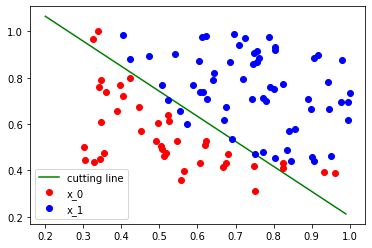

In [116]:
# 画出更新之后的结果
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0.numpy() * plot_x - b0.numpy()) / w1.numpy()

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

可以看到更新之后模型已经能够基本将这两类点分开了

### 1. 5 PyTorch的Loss函数
前面我们使用了自己写的 loss，其实 PyTorch 已经为我们写好了一些常见的 loss，比如线性回归里面的 loss 是 `nn.MSE()`，而 Logistic 回归的二分类 loss 在 PyTorch 中是 `nn.BCEWithLogitsLoss()`，关于更多的 loss，可以查看[文档](http://pytorch.org/docs/0.3.0/nn.html#loss-functions)

PyTorch 为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

另外，PyTorch 出于稳定性考虑，将模型的 Sigmoid 操作和最后的 loss 都合在了 `nn.BCEWithLogitsLoss()`，所以我们使用 PyTorch 自带的 loss 就不需要再加上 Sigmoid 操作了

In [117]:
# 使用自带的loss
criterion = nn.BCEWithLogitsLoss() # 将 sigmoid 和 loss 写在一层，有更快的速度、更好的稳定性

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_reg(x):
    return torch.mm(x, w) + b

optimizer = torch.optim.SGD([w, b], 1.)

In [118]:
y_pred = logistic_reg(x_data)
loss = criterion(y_pred, y_data)
print(loss.data)

tensor(0.6314)


In [119]:
# 同样进行 1000 次更新

start = time.time()
for e in range(1000):
    # 前向传播
    y_pred = logistic_reg(x_data)
    loss = criterion(y_pred, y_data)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 计算正确率 0.5以上的判断为正确
    mask = y_pred.ge(0.5).float()        
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.item(), acc))

during = time.time() - start
print()
print('During Time: {:.3f} s'.format(during))

epoch: 200, Loss: 0.39446, Acc: 0.88000
epoch: 400, Loss: 0.32373, Acc: 0.87000
epoch: 600, Loss: 0.29020, Acc: 0.87000
epoch: 800, Loss: 0.27049, Acc: 0.87000
epoch: 1000, Loss: 0.25745, Acc: 0.88000

During Time: 0.232 s


可以看到，使用了 PyTorch 自带的 loss 之后，速度有了一定的上升，虽然看上去速度的提升并不多，但是这只是一个小网络，对于大网络，使用自带的 loss 不管对于稳定性还是速度而言，都有质的飞跃，同时也避免了重复造轮子的困扰